In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data1 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv", encoding='latin1')
data2 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv", encoding='latin1')
data3 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv", encoding='latin1')
data4 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", encoding='latin1')
data5 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", encoding='latin1')
data6 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv", encoding='latin1')
data7 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", encoding='latin1')
data8 = pd.read_csv("/home/wahba/Documents/dataset/cicid/cicids2017/original/csv/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", encoding='latin1')

data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

for data in data_list:
    print(data.shape)

# Merge datasets
data = pd.concat(data_list, ignore_index=True)
print("Merged data shape:", data.shape)

# Remove dataframes to free up memory
for d in data_list: del d

data.columns = data.columns.str.strip()

(529918, 79)
(445909, 79)
(692703, 79)
(170366, 79)
(288602, 79)
(191033, 79)
(286467, 79)
(225745, 79)
Merged data shape: (2830743, 79)


In [3]:
data['Label'].value_counts()

Label
BENIGN                          2273097
DoS Hulk                         231073
PortScan                         158930
DDoS                             128027
DoS GoldenEye                     10293
FTP-Patator                        7938
SSH-Patator                        5897
DoS slowloris                      5796
DoS Slowhttptest                   5499
Bot                                1966
Web Attack ï¿½ Brute Force         1507
Web Attack ï¿½ XSS                  652
Infiltration                         36
Web Attack ï¿½ Sql Injection         21
Heartbleed                           11
Name: count, dtype: int64

# 1.0 Dataset Cleaning

## 1.1 Handling duplicate values

### 1.1.1 Removing duplicate rows

In [4]:
# Duplicate rows
duplicates = data[data.duplicated()]
print("Number of duplicate rows:", len(duplicates))
data = data.drop_duplicates()
del duplicates

Number of duplicate rows: 308381


### 1.1.2 Removing duplicate columns

In [5]:
# Duplicate columns
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


## 1.2 Handling columns with no variance (only one unique value)

In [6]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

Bwd PSH Flags

The number of columns with only one unique values is: 1


## 1.3 Handling missing and infinity values

Missing values in each column:
 Flow Bytes/s    353
dtype: int64
Infinity values in each numeric column:
 Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64
Missing values in each column after infinity values handling:
 Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64
Median of 'Flow Bytes/s': 3715.0378579999997
Median of 'Flow Packets/s': 69.742244285


/tmp/ipykernel_3703/4271281863.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Flow Bytes/s'].fillna(med_flow_bytes, inplace=True)
/tmp/ipykernel_3703/4271281863.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

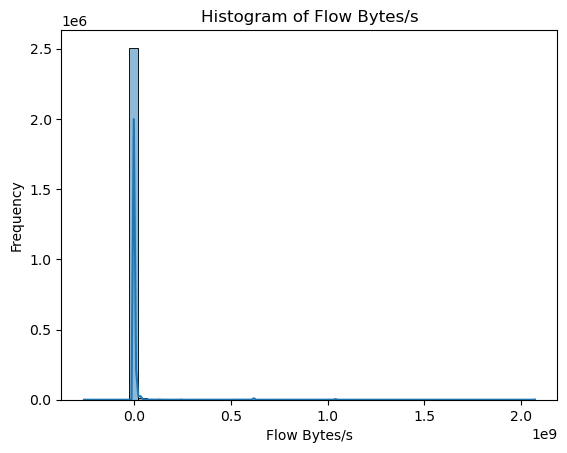

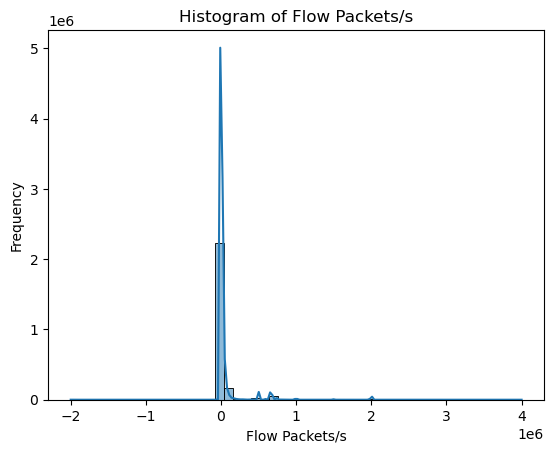

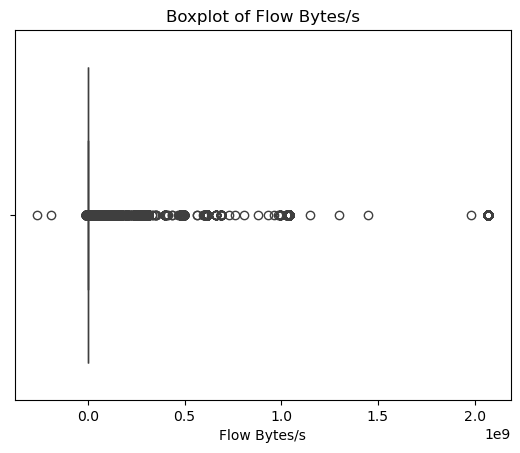

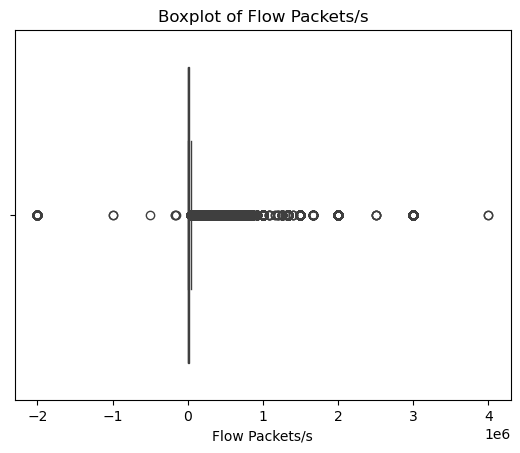

In [7]:
# Identify missing values
missing_values = data.isnull().sum() # Check for missing values in each column
print("Missing values in each column:\n", missing_values[missing_values > 0]) # Display only columns with missing values

# Identify infinity values
numeric_columns = data.select_dtypes(include=[np.number]).columns
infinity_counts = (data[numeric_columns] == np.inf).sum()
print("Infinity values in each numeric column:\n", infinity_counts[infinity_counts > 0]) # Display only columns with infinity values

# Replace infinity values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Identify missing values
missing_values = data.isnull().sum() # Check for missing values in each column
print("Missing values in each column after infinity values handling:\n", missing_values[missing_values > 0]) # Display only columns with missing values

# Filling missing values with median of each column
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'].fillna(med_flow_bytes, inplace=True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace=True)

print("Median of 'Flow Bytes/s':", med_flow_bytes)
print("Median of 'Flow Packets/s':", med_flow_packets)

cols = ["Flow Bytes/s", "Flow Packets/s"]

data_viz = data.copy()

for col in cols:
    plt.figure()
    sns.histplot(data_viz[col].dropna(), bins=50, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

for col in cols:
    plt.figure()
    sns.boxplot(x=data_viz[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# 2.0 Columns correlation analysis

###  Correlation heatmap

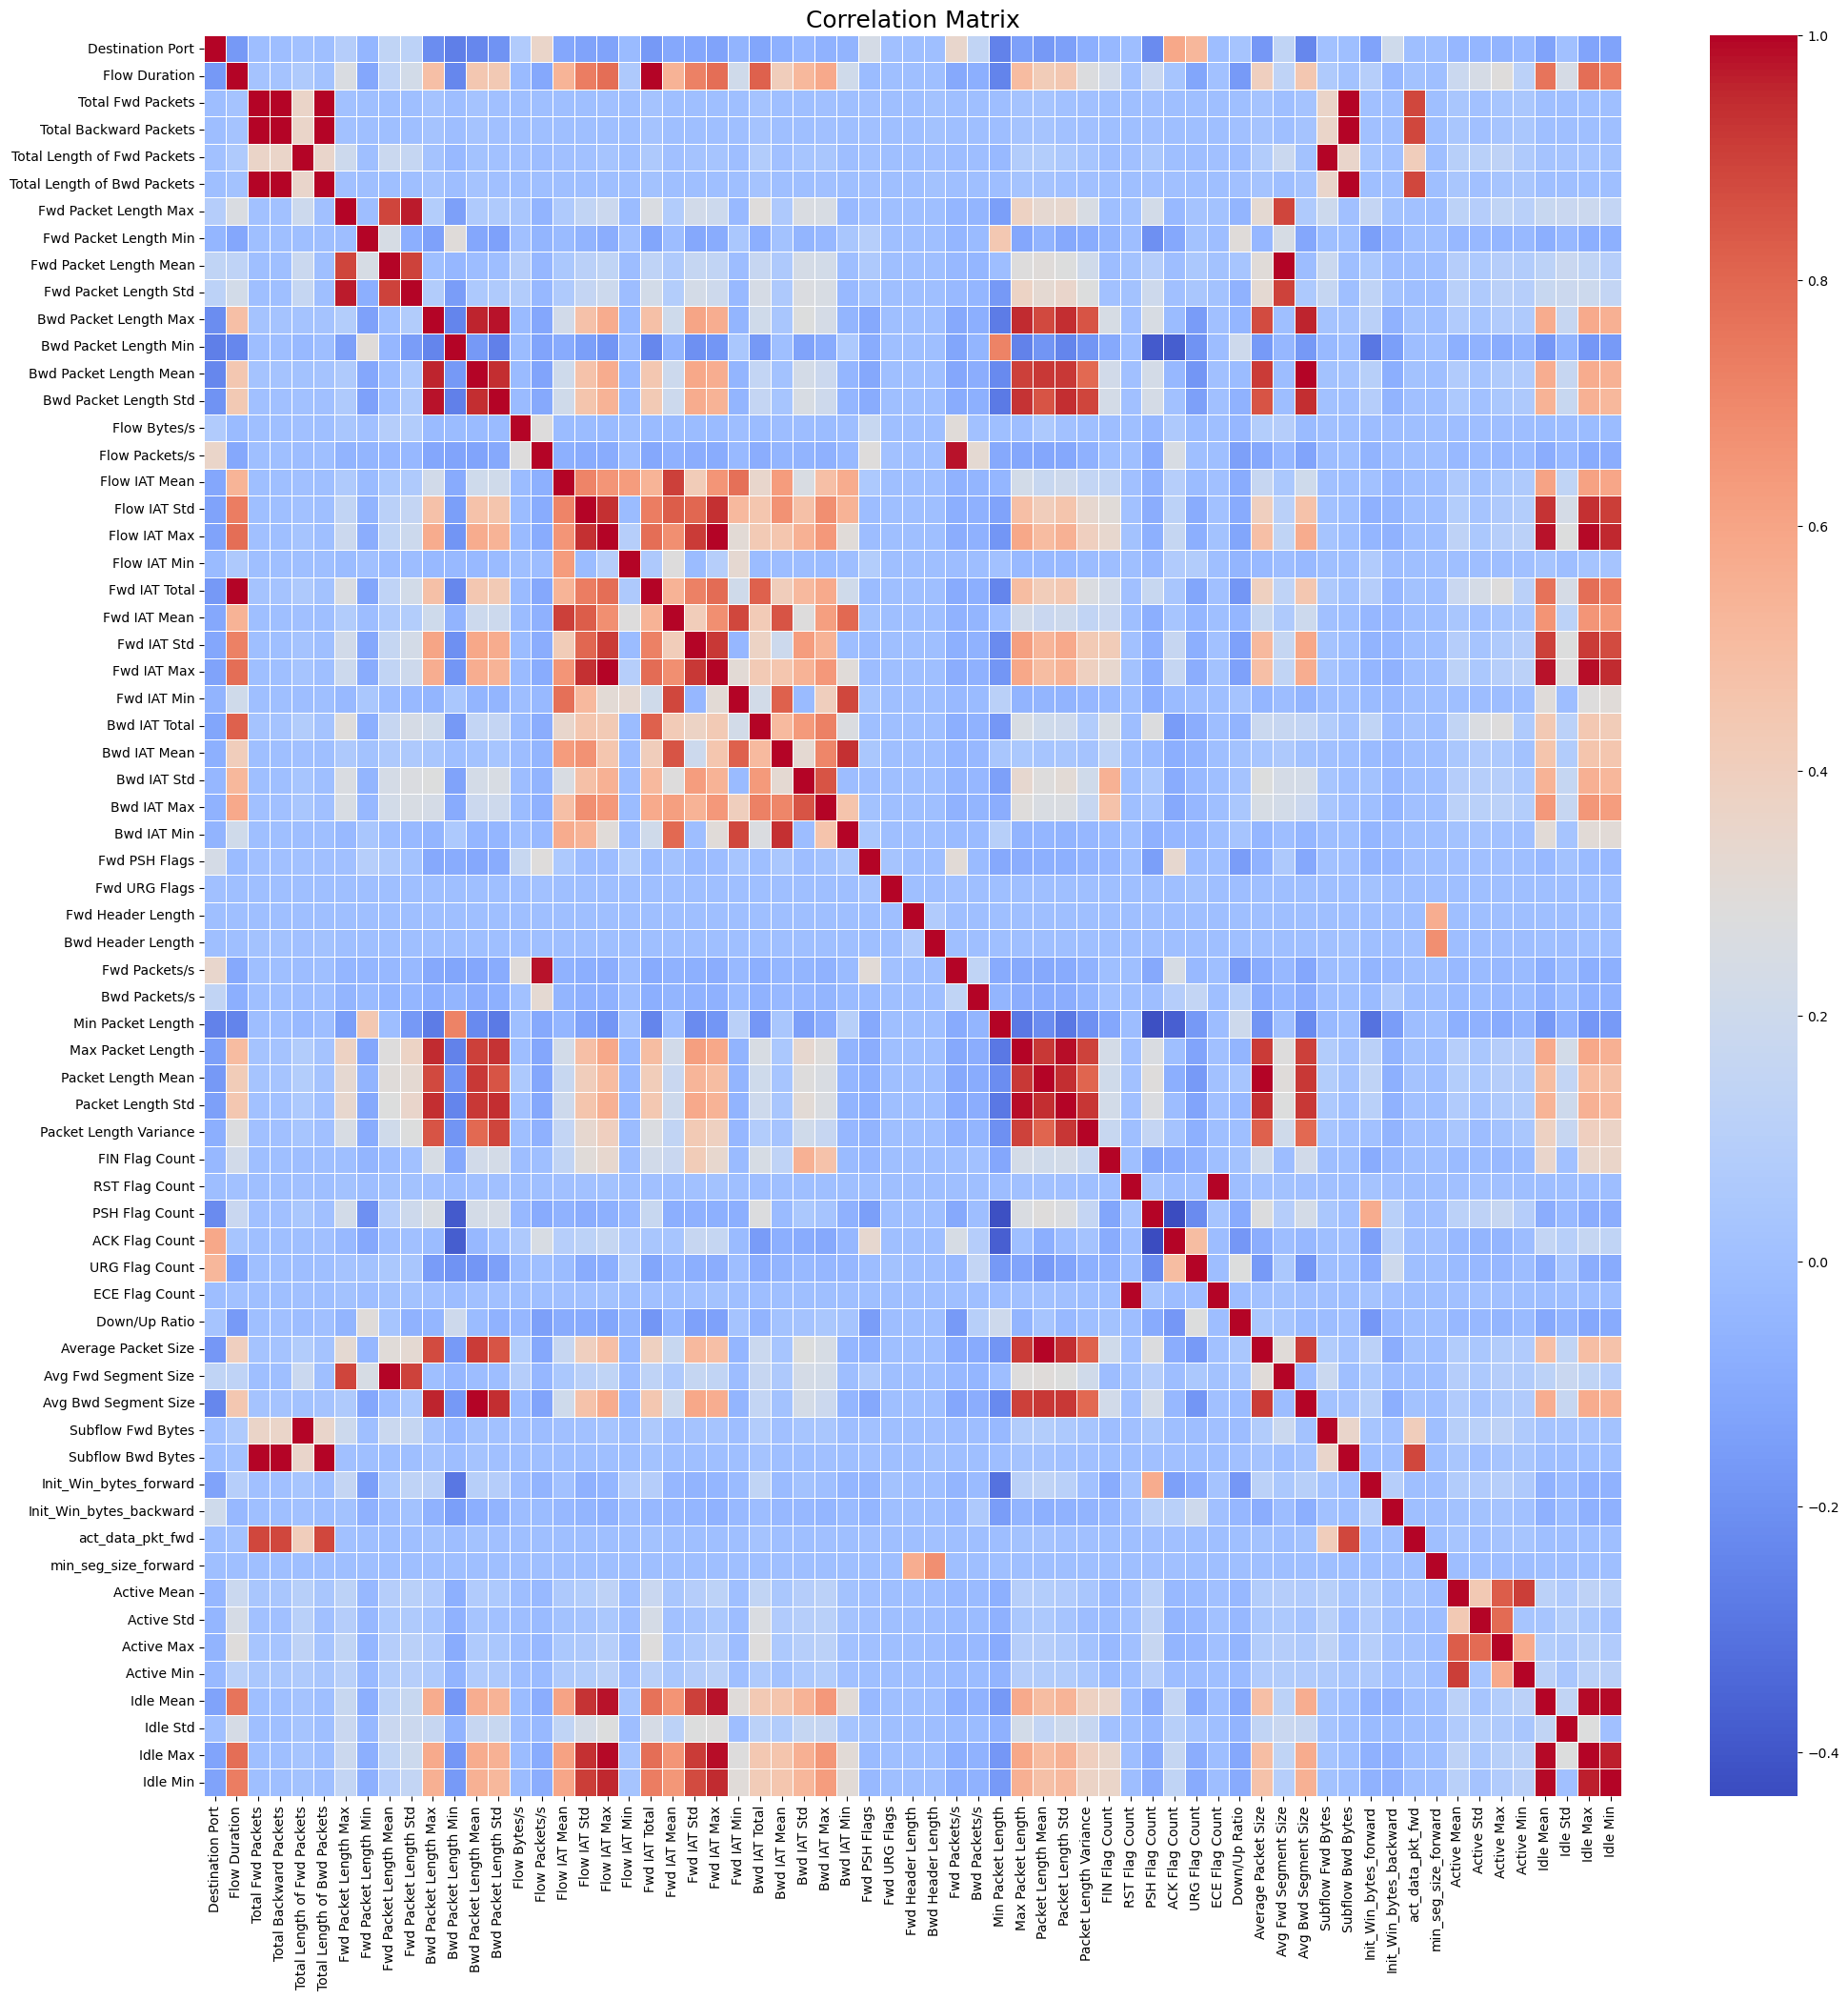

In [8]:
correlation = data.corr(numeric_only=True)

correlation.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(correlation, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()
     

In [9]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []

high_corr = np.where(np.abs(correlation) > 0.85)
high_corr = [(correlation.index[x], correlation.columns[y], correlation.iloc[x, y])
                for x, y in zip(*high_corr) if x != y and x < y]

for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9944
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.8889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.96

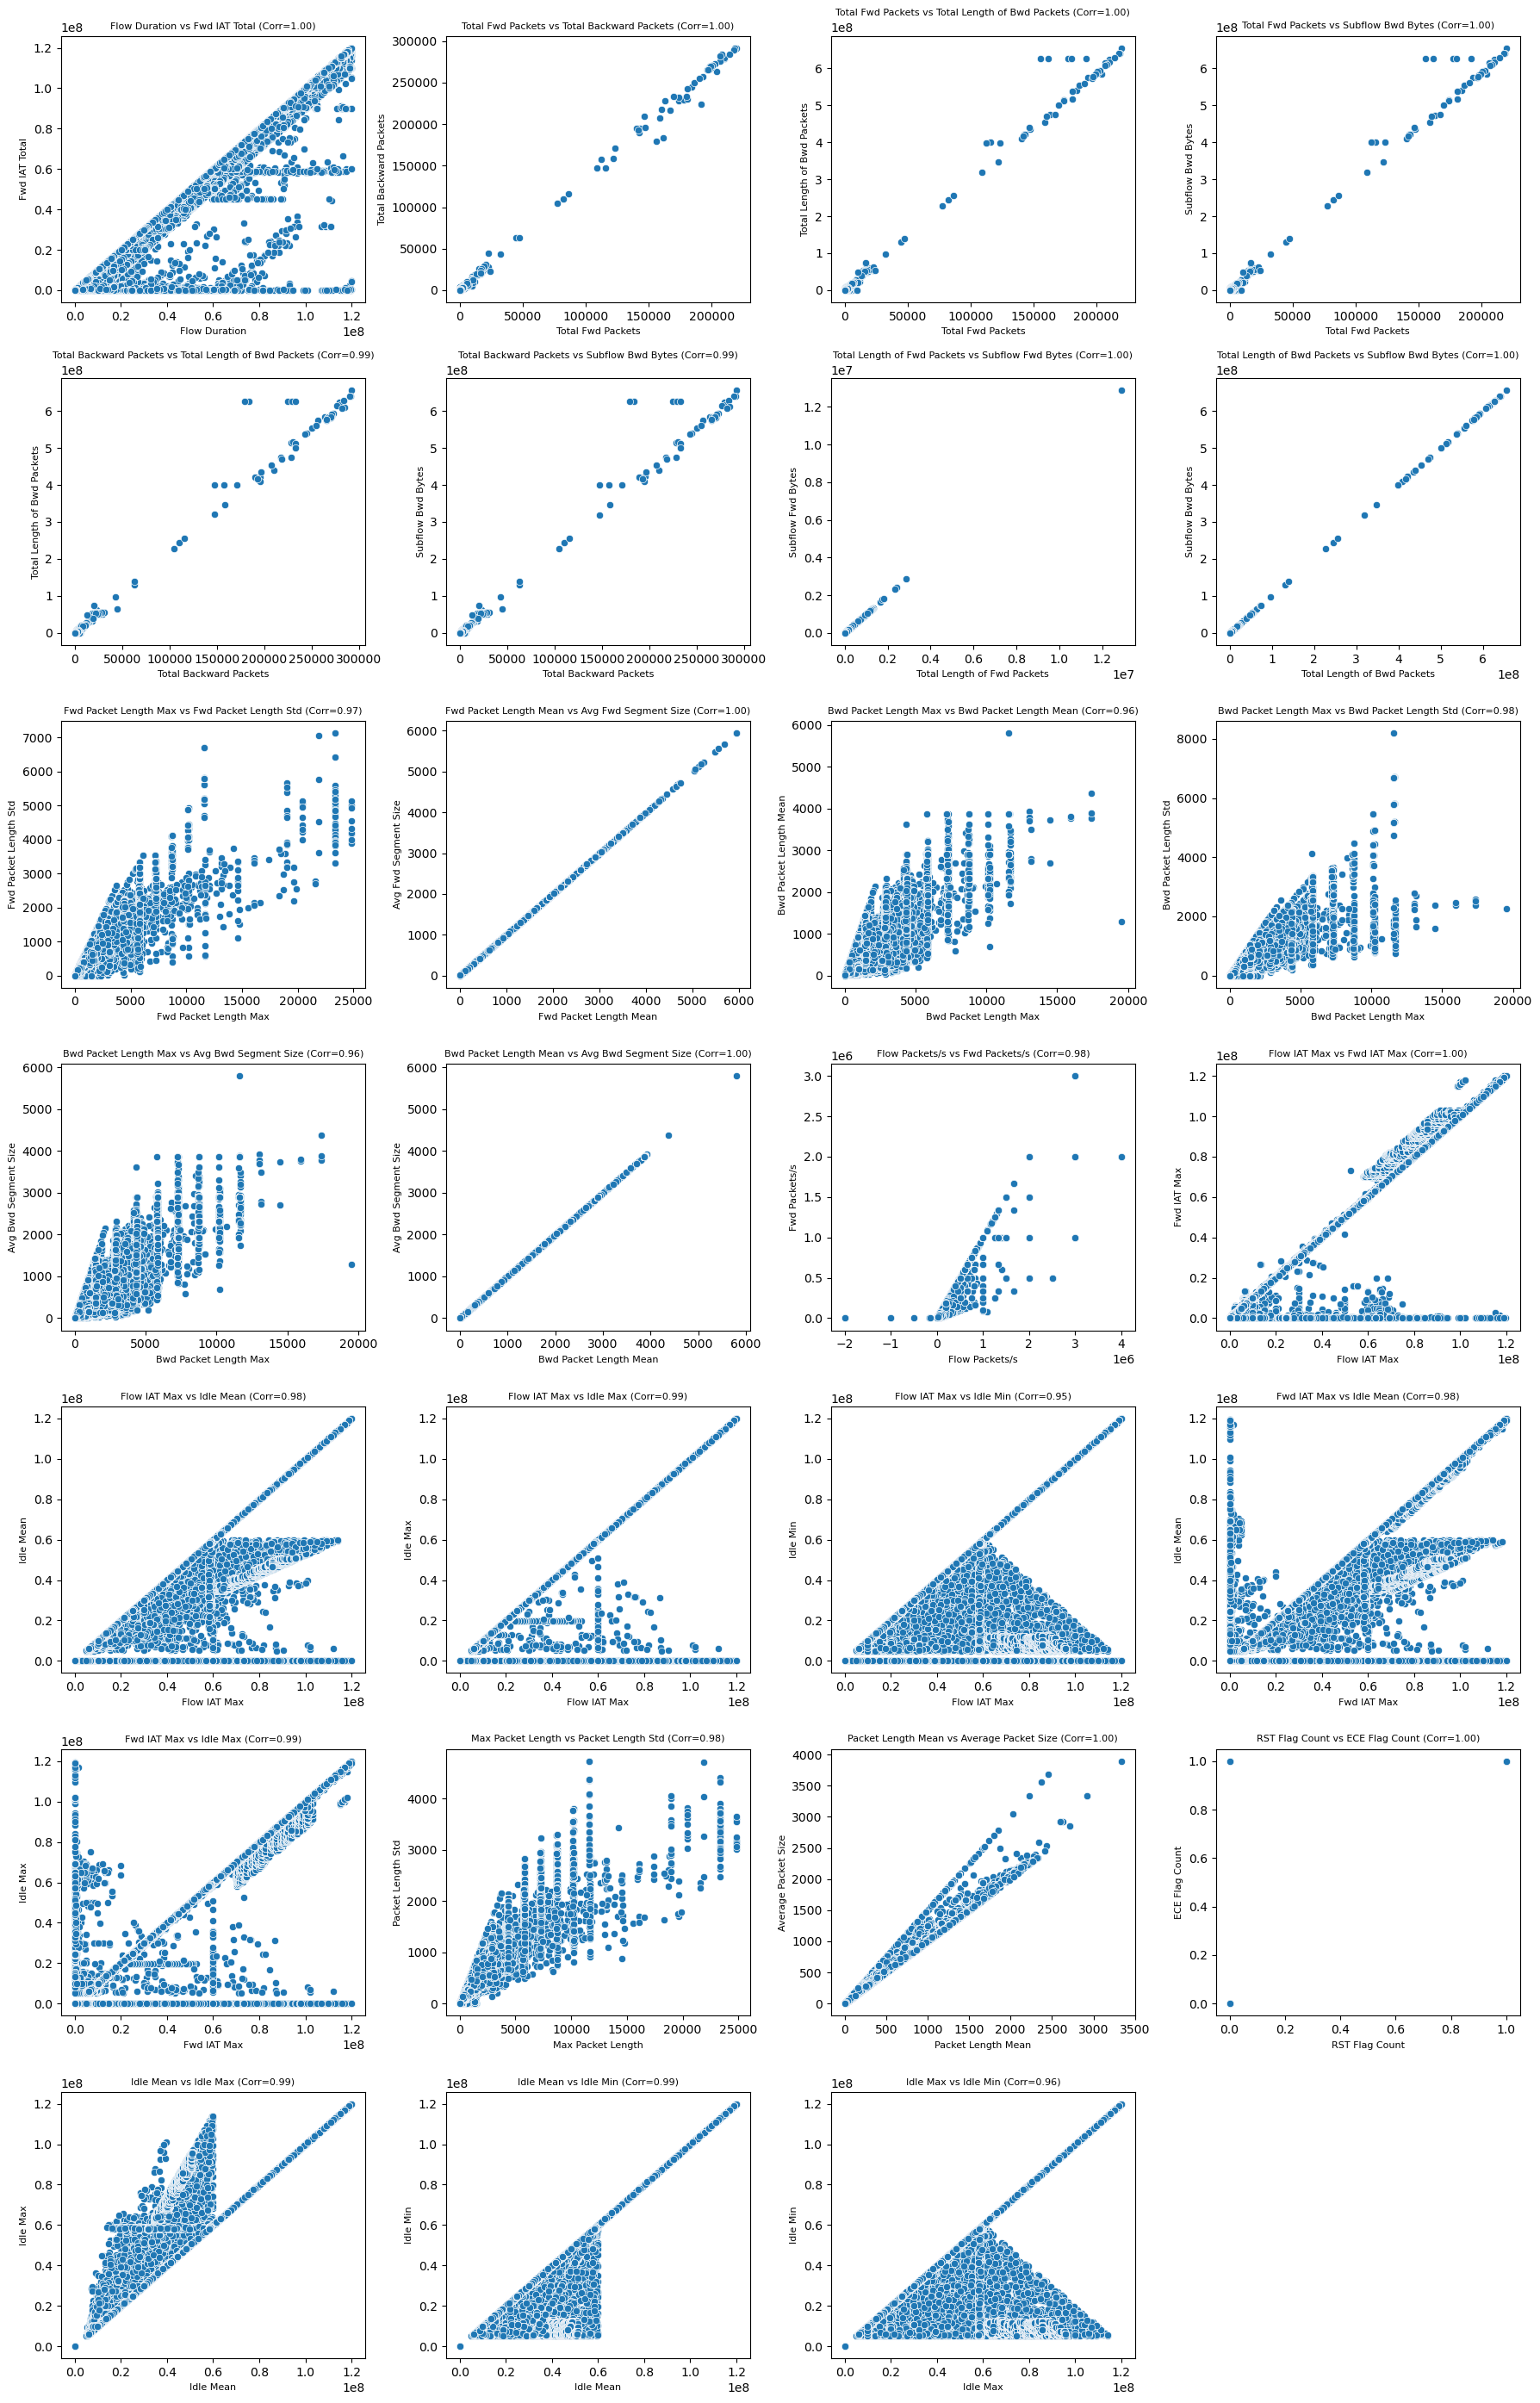

In [10]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

# 3.0 Renaming and Grouping Label 

In [12]:
# Exploring data
data['Label'].value_counts()

Label
BENIGN                          2096484
DoS Hulk                         172849
DDoS                             128016
PortScan                          90819
DoS GoldenEye                     10286
FTP-Patator                        5933
DoS slowloris                      5385
DoS Slowhttptest                   5228
SSH-Patator                        3219
Bot                                1953
Web Attack ï¿½ Brute Force         1470
Web Attack ï¿½ XSS                  652
Infiltration                         36
Web Attack ï¿½ Sql Injection         21
Heartbleed                           11
Name: count, dtype: int64

In [13]:
# Remap label to attack types
attack_mapping = {
    'BENIGN': 'Benign',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DDoS': 'DoS',
    'FTP-Patator': 'BruteForce',
    'SSH-Patator': 'BruteForce',
    'Web Attack ï¿½ Brute Force': 'WebAttack',
    'Web Attack ï¿½ XSS': 'WebAttack',
    'Web Attack ï¿½ Sql Injection': 'WebAttack',
    'Infiltration': 'Infiltration',
    'Bot': 'Bot',
}
data['Label'] = data['Label'].map(attack_mapping)
data['Label'].value_counts()


Label
Benign          2096484
DoS              321764
PortScan          90819
BruteForce         9152
WebAttack          2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

# Save cleaned data

In [14]:
# Full dataset
data.to_csv('/home/wahba/Documents/dataset/processed/1_cicids2017_full.csv', index=False)

# Attack and Benign only
attack_and_benign = data.copy()
# Define which labels are considered attacks
attack_labels = ['DoS', 'PortScan', 'BruteForce', 'WebAttack', 'Bot', 'Infiltration', 'Heartbleed']
# Replace them with "Attack"
attack_and_benign['Label'] = data['Label'].replace(attack_labels, 'Attack')
data.to_csv('/home/wahba/Documents/dataset/processed/2_cicids2017_benign_attack.csv', index=False)

# Attack only
attack_only = data[data['Label'] != 'Benign']
attack_only.to_csv('/home/wahba/Documents/dataset/processed/3_cicids2017_attack_only.csv', index=False)